In [ ]:
# -*- coding: utf-8 -*-
import cv2
from pylab import *

img_id = 6
img_path = '/home/zhulei/Data/pg_data/Queries/{:02d}.jpg'.format(img_id)
img = cv2.imread(img_path)
# img_RGB= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

siftDetector=cv2.xfeatures2d.SIFT_create()
kp,des = siftDetector.detectAndCompute(img_gray, None)
# 关键点列表
print(type(kp),len(kp))
# des是一个大小为关键点数目*128的数组
print(type(des),des.shape)
img_show=cv2.drawKeypoints(img_RGB,kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#用pylab的imshow()显示
figure()
gray()
subplot(111)
axis('off')
imshow(img_show)

#用Opencv管理窗口显示
#cv2.imshow('Sift detect',im);
#cv2.waitKey(0)
#cv2.destroyAllWindows()

show()

In [14]:
complete_dir = '/home/zhulei/Data/pg_data/Images'
test_dir = './Images'
os.makedirs(test_dir, exist_ok=True)

img_names = os.listdir(complete_dir)[:20]
for img_name in img_names:
    src_path = os.path.join(complete_dir, img_name)
    tgt_path = os.path.join(test_dir, img_name)
    img = cv2.imread(src_path)
    cv2.imwrite(tgt_path, img)

In [45]:
import numpy as np
import cv2
import sklearn
import joblib
import random
import copy
import numpy as np
import os
from sklearn import cluster, neighbors

SEED=10086
np.random.seed(SEED)
random.seed(SEED)


class ImageDB:
    def __init__(self, im_fea_name='bow', pt_fea_name='sift', vsize=4096, top_k=50):
        self.im_fea_support = ['bow', 'tfidf']
        self.pt_fea_support = ['sift']
        assert im_fea_name in self.im_fea_support
        assert pt_fea_name in self.pt_fea_support
        self.im_fea_name = im_fea_name
        self.pt_fea_name = pt_fea_name
        self.vsize = vsize
        self.top_k = top_k
        
        if pt_fea_name == 'sift':
            self.pt_fea_extractor = cv2.xfeatures2d.SIFT_create()
        else:
            raise NotImplementedError("Pont feature extraction method {:s} is not implemented!".format(pt_fea_name))
         
        if im_fea_name == 'tfidf':
            self.tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer(norm='l1')
            
        self.num_imgs = None
        
        self.kmeans = None
        self.knn = None
        
        self.im_dir = None
        self.im_name_list = None
#         self.im_path_list = None
        # im_fea_mat is a matrix of shape (num_imgs, vsize)
        self.im_fea_mat = None
        # pt_fea_mat_list is a list of length num_imgs
        # each element is a descriptor matrix of shape (*, 128)
        self.pt_fea_mat_list = None
        
          
    def build(self, img_db_dir, cluster_pt_ratio=1.0):
        print('Extracting pixel-level features...')
        self.im_dir = img_db_dir
        self.im_name_list = sorted(os.listdir(img_db_dir))
#         self.im_path_list = [ os.path.join(img_db_dir, img_name) for img_name in img_names ]
        self.pt_fea_mat_list = []
        for im_name in self.im_name_list:
            im_path = os.path.join(self.im_dir, im_name)
            im_bgr = cv2.imread(im_path)
            kp, des = self._compute_pt_fea(im_bgr)
            # kp cannot be serialized using pickle, we just simply throw it
            self.pt_fea_mat_list.append(des)
        
        # get cluster center
        des_mat_all = np.concatenate(self.pt_fea_mat_list, axis=0)
        print('{:d} key points have been found in {:d} images!'.format(len(des_mat_all),
                                                                       len(self.im_name_list)))
        cluster_pt_num = int(cluster_pt_ratio * des_mat_all.shape[0])
        print('Running KMeans clustering for {:d} key points with {:d} centers...'.format(cluster_pt_num, self.vsize))
        np.random.shuffle(des_mat_all)
        self.kmeans = cluster.KMeans(n_clusters=self.vsize,
                                     random_state=SEED,
                                     n_jobs=-1)
        self.kmeans.fit(des_mat_all[:cluster_pt_num])
        
        print('Building image-level feature matrix...')
        # build bow feature matrix for images in database
        self.num_imgs = len(self.im_name_list)
        self.im_fea_mat = []
        for i in range(self.num_imgs):
            cur_hist = self._compute_im_bow(self.pt_fea_mat_list[i])
            self.im_fea_mat.append(cur_hist)
        self.im_fea_mat = np.stack(self.im_fea_mat, axis=0)
                
        if self.im_fea_name == 'tfidf':
            self.im_fea_mat = self.tfidf_transformer.fit_transform(self.im_fea_mat)
            
        print('Building KNN for image retrieval...')
        # to search most similar images, here we use sklearn's KNN
        self.knn = neighbors.NearestNeighbors(n_neighbors=self.top_k,
                                              n_jobs=-1)
        self.knn.fit(self.im_fea_mat)
        print('Finished!')
        
    
    def retrieve(self, query_img, top_k=50):
        if top_k is None:
            top_k = self.top_k
        kp, des = self._compute_pt_fea(query_img)
        img_fea = np.expand_dims(self._compute_im_bow(des), axis=0)
        if self.im_fea_name == 'tfidf':
            img_fea = self.tfidf_transformer.transform(img_fea)
        dists, inds = self.knn.kneighbors(img_fea, top_k, return_distance=True)
        similar_imgs = []
        for cnt, im_idx in enumerate(inds[0]):
            similar_im_path = os.path.join(self.im_dir, self.im_name_list[im_idx])
            similar_imgs.append((similar_im_path, dists[0][cnt]))
        return similar_imgs
    
    
    def _compute_pt_fea(self, im_bgr):
        '''
        args:
            img: cv2 BGR image
        return:
            (kp, des): kp is a list containing n feature point coordinate (cv2.Keypoint object),
                       des is a matrix of shape (n, 128)
        '''
         # sift is an algorithm for grayscale image, here we do conversion explicitly
         # https://stackoverflow.com/a/41290545
        im_gray = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2GRAY)
        kp, des = self.pt_fea_extractor.detectAndCompute(im_gray, None)
        return kp, des
    
    
    def _compute_im_bow(self, pt_fea_mat):
        '''
        args:
            pt_fea_mat: a descriptor matrix of shape (n, 128)
        return:
            hist: a histogram of visual word frequency, shape (vsize, )
        '''
        num_fea_pt = pt_fea_mat.shape[0]
        hist = np.zeros(self.vsize)
        word_idx = self.kmeans.predict(pt_fea_mat)
        for pt_idx in range(num_fea_pt):
            hist[word_idx[pt_idx]] += 1
        return hist
            
        
    def save(self, path):
        # sift detector cannot be serialized, simply skip this attribute
        skip_key = ['pt_fea_extractor']
        state_dict = {}
        for k, v in self.__dict__.items():
            if k not in skip_key:
                state_dict[k] = v
        joblib.dump(state_dict, path)
        
    def load(self, path):
        # may partially load necessary attributes
        state_dict = joblib.load(path)
        for attrname, value in state_dict.items():
            setattr(self, attrname, value)
            
    def __len__(self):
        return self.num_imgs
        



# def main():
#     fea_db_file = 
#     img_db_dir = 
#     query_img_path = 
    
    
#     fea_db = FeatureDB(feature='bow')
#     query_img = cv2.imread(query_img_path)
#     if os.exists(fea_db_file):
#         fea_db.load(fea_db_file)
#     else:
#         fea_db = fea_db.build(img_db_dir)
#         fea_db.save(fea_db_file)
#     dists, similar_paths = fea_db.query(query_img, top_k=50)
 
    
    
     
    

In [46]:
test_dir = './Images'
im_db = ImageDB(vsize=256)
im_db.build(test_dir, 0.5)

Extracting pixel-level features...
85822 key points have been found in 20 images!
Running KMeans clustering for 42911 key points with 256 centers...
Building image-level feature matrix...
Building KNN for image retrieval...
Finished!


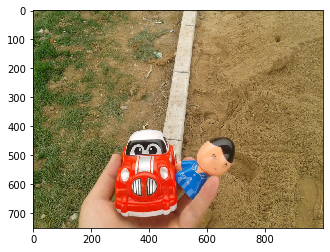

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
img_name_query = os.listdir(test_dir)[0]
img_path_query = os.path.join(test_dir, img_name_query)
img_query = cv2.imread(img_path_query)
plt.imshow(img_query[:, :, ::-1])

In [53]:
similar_imgs = im_db.retrieve(img_query, 5)

/home/zhulei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


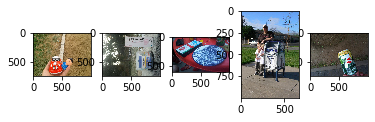

In [54]:
plt.subplot(155)
for i, (im_path, score) in enumerate(similar_imgs):
    im = cv2.imread(im_path)
    plt.subplot(151 + i)
    plt.imshow(im[:, :, ::-1])
plt.show()

In [55]:
print(similar_imgs)

[('./Images/00698.jpg', 0.0), ('./Images/05019.jpg', 291.48241799463653), ('./Images/04023.jpg', 365.042463283383), ('./Images/28315.jpg', 378.65683672687067), ('./Images/01352.jpg', 379.760450810771)]


In [56]:
im_db.save('test.joblib')

In [57]:
im_db_copy = ImageDB()
im_db_copy.load('test.joblib')
similar_imgs = im_db_copy.retrieve(img_query, 5)
print(similar_imgs)

[('./Images/00698.jpg', 0.0), ('./Images/05019.jpg', 291.48241799463653), ('./Images/04023.jpg', 365.042463283383), ('./Images/28315.jpg', 378.65683672687067), ('./Images/01352.jpg', 379.760450810771)]


## Build image DB for all images

In [58]:
cluster_pt_ratio = 0.1
vsize = 1024
im_dir = '/home/zhulei/Data/pg_data/Images'
save_name = 'cpr{:.2f}_vsize{:d}_db.joblib'

im_db_all = ImageDB(vsize=vsize)
im_db_all.build(im_dir, cluster_pt_ratio)
im_db_all.save(save_name)

Extracting pixel-level features...


MemoryError: Unable to allocate array with shape (84491755, 128) and data type float32